(example_3)=
# Example 3: Multi-armed bandit task

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_2_Input_node_volatility_coupling.ipynb)

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install pyhgf

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
from scipy.stats import norm

from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF

In this notebook, we are going to illustrate how to fit behavioural responses from a two-armed bandit task. The task is similar to what was used in {cite:p}`Pulcu2017`. This is a two-armed bandit task with independent reward and punishment outcomes. 

## A double multi-armed bandit task
Because the reward and punishments are independent, we simulate the task using four binary HGF.

```{note}
While the binary HGF is a special case of the categorical HGF where the number of categories is set to 2, the categorical HGF add a volatility coupling between the binary branch (see {ref}`categorical_hgf`). Therefore a categorical HGF would not be suitable here as we want every branch of the network to evelove independently.
```

Initializing a network with custom node structure.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.


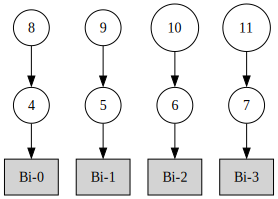

In [12]:
two_armed_bandit_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="binary", input_idxs=0)
    .add_input_node(kind="binary", input_idxs=1)
    .add_input_node(kind="binary", input_idxs=2)
    .add_input_node(kind="binary", input_idxs=3)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[2])
    .add_value_parent(children_idxs=[3])
    .add_value_parent(children_idxs=[4], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[5], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[6], tonic_volatility=-1.0)
    .add_value_parent(children_idxs=[7], tonic_volatility=-1.0)
    .init()
)
two_armed_bandit_hgf.plot_network()

## Task structure
We start with a simple task structure where contingencies (i.e. the probability that a given armed bandit is associated with a win/loss) alternate between `0.2`, `0.5` and `0.8`. The rate of change in contingencies can be fast (i.e. high volatility blocks) or slow (i.e. low volatility blocks).

In [13]:
# three levels of probability
high_prob, chance, low_prob = 0.8, 0.5, 0.2

# create blocks of contingencies
stable_contingencies = np.array([low_prob, high_prob]).repeat(20)
volatile_contingencies = np.tile(np.array([low_prob, high_prob]).repeat(10), 3)
chance_contingencies = np.array(chance).repeat(40)

In [14]:
# create sequences of blocks for the different cases
win_arm1 = np.concatenate([stable_contingencies, chance_contingencies, volatile_contingencies])
loss_arm1 = np.concatenate([volatile_contingencies, chance_contingencies, stable_contingencies])
win_arm2 = np.concatenate([chance_contingencies, stable_contingencies, volatile_contingencies])
loss_arm2 = np.concatenate([chance_contingencies, volatile_contingencies, stable_contingencies])

In [15]:
# sample trial level outcomes from the sequences
u_win_arm1 = np.random.binomial(n=1, p=win_arm1)
u_loss_arm1 = np.random.binomial(n=1, p=loss_arm1)
u_win_arm2 = np.random.binomial(n=1, p=win_arm2)
u_loss_arm2 = np.random.binomial(n=1, p=loss_arm2)

This gives the following task structure:

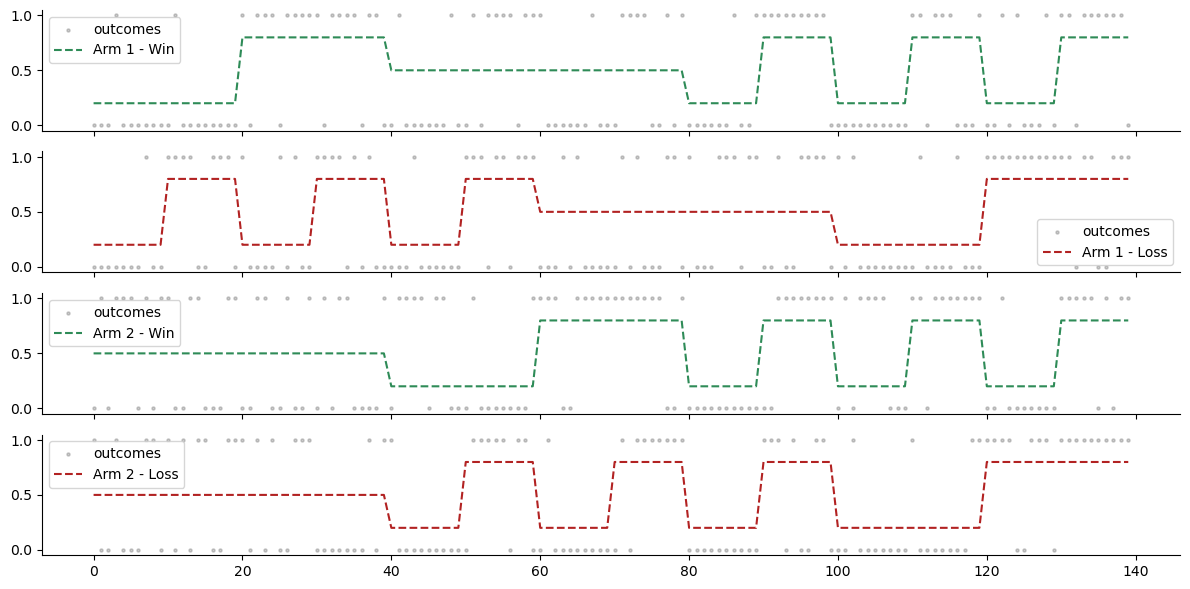

In [16]:
# trial numbers
trials = np.arange(len(win_arm1))

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True)

for i, u, p, label, color in zip(
    range(4),
    [u_win_arm1, u_loss_arm1, u_win_arm2, u_loss_arm2], 
    [win_arm1, loss_arm1, win_arm2, loss_arm2], 
    ["Arm 1 - Win", "Arm 1 - Loss", "Arm 2 - Win", "Arm 2 - Loss"],
    ["seagreen", "firebrick", "seagreen", "firebrick"]
):
    axs[i].scatter(trials, u, label="outcomes", alpha=.4, s=5, color="gray")
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend()
plt.tight_layout()
sns.despine();

## Simulate a dataset

We can simlate our vector of observation. This is a two dimentional matrix with input observations for the four components of our model. 

In [17]:
u = np.array([u_win_arm1, u_loss_arm1, u_win_arm2, u_loss_arm2])

From there, it is straightforward to feed these observations to our four branches HGF to retrieve the trajectories.

```{note}
Here, we are providing all the outcomes from all trials. This is not how the task would work as the participant will only be presented with the outcomes from the armed bandit chosen, and we are not using responses from the participant yet. See also {ref}`custom_response_functions` for details on the observations `u` and the responses `y`.
```

In [18]:
two_armed_bandit_hgf.input_data(input_data=u.T);

Adding 140 new observations.


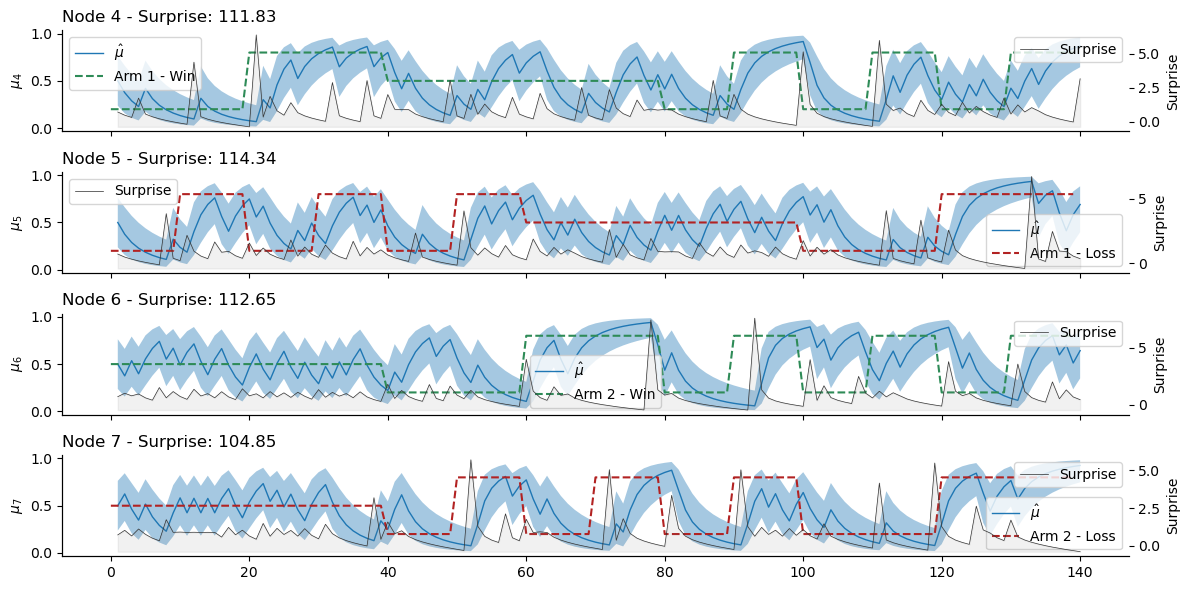

In [20]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_armed_bandit_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_armed_bandit_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_armed_bandit_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_armed_bandit_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [win_arm1, loss_arm1, win_arm2, loss_arm2], 
    ["Arm 1 - Win", "Arm 1 - Loss", "Arm 2 - Win", "Arm 2 - Loss"],
    ["seagreen", "firebrick", "seagreen", "firebrick"]
):
    axs[i].plot(trials, p, "--", label=label, color=color)
    axs[i].legend()

plt.tight_layout()
sns.despine();

## System configuration

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib